# CMPS 392 - Machine Learning 

## *Assignment 6*: Regularization

##### **Mohamed Nassar, Spring 2020**

---

## Ex 1
### Data Augmentation 
In this experiment we aim to classify grocery images. In the same time, it is a first pytorch tutorial, maybe you will like it even more than tensorflow or keras! 

We also will experiment with transfer learning since we will use a pretrained network and only change its output layer!

Show that data augmentation using image transormations improves the generalization performance (testing loss - training loss) of our classifier 

In pytorch, it is easy to inject random data transformation using the torchvision.transforms module 

Try as much transformations as you like and report with your remarks

Reference: https://pytorch.org/docs/stable/torchvision/transforms.html


In [0]:
# run only one time to download the dataset 
! git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6553, done.
remote: Total 6553 (delta 0), reused 0 (delta 0), pack-reused 6553
Receiving objects: 100% (6553/6553), 116.24 MiB | 41.15 MiB/s, done.
Resolving deltas: 100% (313/313), done.


In [0]:
import os
import random
import PIL.Image
import numpy as np 
import matplotlib.pyplot as plt 

images_path=[]
labels=[]
for dir, subdir, files in os.walk("/content/GroceryStoreDataset/dataset/train/"):
    # print (files)
    for file in files:        
        images_path.append(os.path.join(dir, file))
        labels.append(dir.split('/')[-1])
       
print (len(labels))
print (len(set(labels)))


2640
81


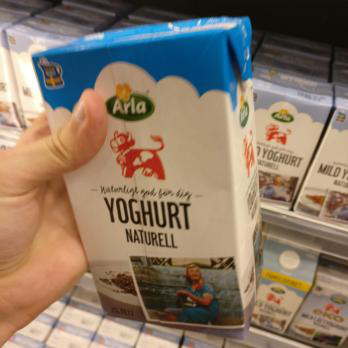

Arla-Natural-Yoghurt


In [0]:
x, y = random.sample( list ( zip(images_path, labels) ), 1)[0]
im = PIL.Image.open(x)
display(im)
print(y) 

In [0]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

class GroceryDataset(Dataset):
    def __init__(self, root, transform=None):
        self.images_path=[]
        self.labels=[]
        for dir, subdir, files in os.walk(root):
          for file in files:
            self.images_path.append(os.path.join(dir, file))
            self.labels.append(dir.split('/')[-1])
        self.transform = transform
        self.classes = dict ( [ (y,x) for (x,y) in enumerate ( set (self.labels) )  ] ) # no for loops
        # classes ["Arla-Natural-Yoghurt"] = 33 


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        target = self.classes [ self.labels[idx] ] 
        im = PIL.Image.open(self.images_path[idx])
        if self.transform:
          im = self.transform(im)
        else: 
          im = transforms.ToTensor()(im)


        return im, target

# data augmentation can be controlled here by adding some random transformations 
transform_ = transforms.Compose([
    transforms.Resize((224,224)),
    # add some random transformations ??
    # rotate the picture, remove parts of the lectures, add some noise // data augmenation 
    
    transforms.ToTensor(),
    # nromalize given means and std deviations 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# data augmentation is only used for training, we do not augment the test data 
# But to raise the challenge maybe you can inject a transformation to the test set
transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    # nromalize given means and std deviations 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


data =  GroceryDataset(root="/content/GroceryStoreDataset/dataset/train/", transform=transform_)
loader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)

testdata =  GroceryDataset(root="/content/GroceryStoreDataset/dataset/test/", transform=transform_test)
testloader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)

# for i in range (3): 
#   for x, y in loader: 
#     print (x.shape, y) 
print (len(data.classes))
print (len(testdata.classes))


81
81


In [0]:
# if it prints cpu, runtime -> change runtime type -> Hardware accelerator -> select gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


In [0]:
from torch import nn
from torch import optim


# take the alexnet neural network and change the last layer 
model = models.alexnet(pretrained=True)
print (model.classifier[6])
model.classifier[6]= nn.Sequential(
    nn.Linear(in_features=4096, out_features=len(data.classes)),
    nn.LogSoftmax(dim=1) ) 

criterion = nn.NLLLoss()

# we just optimize with respect to the last layer weights and biases! 
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.003)

model.to(device)
model

Linear(in_features=4096, out_features=1000, bias=True)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
epochs = 10
steps = 0
running_loss = 0


for epoch in range(epochs):
  for inputs, labels in loader:
      # print (inputs.shape)
      steps += 1
      # Move input and label tensors to the default device
      inputs= inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      logps = model.forward(inputs)
      loss = criterion(logps, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
  print(f"Epoch {epoch+1}/{epochs}.. "
      f"Train loss: {running_loss/len(loader):.3f}.. ")
  running_loss = 0
          

test_loss = 0
test_accuracy = 0
model.eval()
with torch.no_grad():
    for inputs_test, labels_test in testloader:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        logps_test = model.forward(inputs_test)
        batch_loss = criterion(logps_test, labels_test)
        test_loss += batch_loss.item()
        # Calculate accuracy
        ps = torch.exp(logps_test)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels_test.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(
      f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {test_accuracy/len(testloader):.3f}")

model.train();



Epoch 1/10.. Train loss: 1.778.. 
Epoch 2/10.. Train loss: 0.415.. 
Epoch 3/10.. Train loss: 0.307.. 
Epoch 4/10.. Train loss: 0.240.. 
Epoch 5/10.. Train loss: 0.188.. 
Epoch 6/10.. Train loss: 0.157.. 
Epoch 7/10.. Train loss: 0.208.. 
Epoch 8/10.. Train loss: 0.189.. 
Epoch 9/10.. Train loss: 0.141.. 
Epoch 10/10.. Train loss: 0.151.. 
Test loss: 0.085.. Test accuracy: 0.972


## Ex 2
### Adversarial training 
In this experiment we generate adversarial images for the grocery dataset and the model that we just learned using a library called foolbox https://github.com/bethgelab/foolbox

Augmenting the original dataset by these adversarial samples helps the regularization of the training model. Use the following skeleton code to generate adversarial samples, add them to the original dataset and comment on your findings in terms of training and testing accuracy. 

In [0]:
# ! pip install foolbox

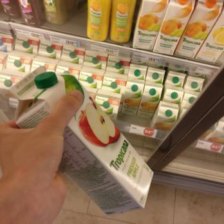

tensor([[True, True]], device='cuda:0')
adv classes:  tensor([[75],
        [75]], device='cuda:0')
true classes:  [tensor(28), tensor(3)]


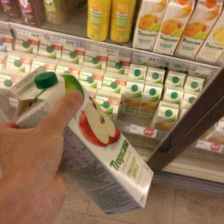

In [0]:
import random, os
import foolbox as fb
import PIL.Image
import torch
from torchvision import datasets, transforms, models
from torch import nn

device = torch.device("cuda:0")
images_path=[]
labels=[]
for dir, subdir, files in os.walk("/content/GroceryStoreDataset/dataset/train/Packages"):
    # print (files)
    for file in files:        
        images_path.append(os.path.join(dir, file))
        labels.append(dir.split('/')[-1])

classes = dict ( [ (y,x) for (x,y) in enumerate ( set (labels) )  ] ) 

ims = [] 
ys = [] 
first = True 
for (x, y) in random.sample( list ( zip(images_path, labels) ), 2):
  y = classes[y]
  im = PIL.Image.open(x)
  im = transforms.Resize((224,224))(im)
  if (first) :
    display(im)
    first = False 
  im = transforms.ToTensor()(im)
  ims.append(im) 
  ys.append(torch.tensor(y))


# print(ys) 
# print (torch.stack(ims).shape)
# print (torch.stack(ys).shape)

# to test separately from the model learned in Ex 1:
# model = models.alexnet(pretrained=True)
# print (model.classifier[6])
# model.classifier[6]= nn.Linear(in_features=4096, out_features=len(set(labels))) 
# model.to(device) 

preprocessing = dict(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010], axis=-3)
fmodel = fb.PyTorchModel(model.eval(), bounds=(0, 1), preprocessing=preprocessing)
attack = fb.attacks.FGSM()
# bigger epsilons lead to more corruption in the image 
epsilons = [0.01]
_, advs, success = attack(fmodel, torch.stack(ims).to(device), torch.stack(ys).to(device), epsilons=epsilons)

print (success)
for x in advs: 
  logps= model.forward(x) 
  ps = torch.exp(logps)
  top_p, top_class = ps.topk(1, dim=1)
  print ("adv classes: ", top_class)
  print ("true classes: ", ys)
  im = transforms.ToPILImage()(x[0].to("cpu"))
  display(im)   
  im = transforms.ToPILImage()(x[1].to("cpu"))
  # display(im) 


## Ex3
### Noise Robustness vs. dropout in the special case of linear regression

(a) Show that adding Gaussian noise with **small** magnitude to the weights and biases of linear regression (the noise has mean $0$ and variance $\eta << 1$) does not affect the solution of the gradient descent. 

(b) Another way of attempting regularization is by adding a dropout layer. Comment on the feasibility and the impact of this approach for the current scenario.


In [0]:
import torch
from torch import nn 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# A x = b 
A = torch.rand(10,3)
A1 = torch.cat ( (A , torch.ones (10,1)), 1 ) 
sol = torch.rand(4,1) 
b = torch.matmul(A1, sol) 
# A1,A,b,
sol

tensor([[0.5491],
        [0.4450],
        [0.0859],
        [0.6499]])

In [0]:
# without adding noise 
model = nn.Linear(in_features=3, out_features=1)
model.to(device)

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)

epochs = 1000

inputs= A.to(device)
labels = b.to(device)



for epoch in range(epochs):
  optimizer.zero_grad()
  preds = model.forward(inputs)
  loss = criterion(preds, labels)

  loss.backward()
  optimizer.step()


model.eval()
preds = model.forward(inputs)
loss = criterion(preds, labels)
print (loss) 
model.train() 

print (model.bias)
print (model.weight)


tensor(1.3726e-06, device='cuda:0', grad_fn=<MseLossBackward>)
Parameter containing:
tensor([0.6465], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[0.5496, 0.4467, 0.0899]], device='cuda:0', requires_grad=True)


## Ex3 
### L2 regularization vs. L1 regularization 
(a) Based on the data provided below, design an experiment to show the difference between the solutions to three **logistic regression** problems:  


1.   the cost function is cross-entropy 
2.   the cost function is cross-entropy + L2 regularization 
3.   the cost function is cross-entropy + L1 regularization 


(b) In the three cases (no regularization, L2 regularization and L1 regularization), compare the weights of the first layer with respect to the variances of the corresponding features and the co-variances of these features w.r.t the label

(c) Show that early stopping is equivalent to L2 regularization for some decay coefficient $\alpha$ 


---


*N.b. some of the code and the data file belong to https://github.com/udacity/deep-learning-v2-pytorch/tree/master/intro-neural-networks/gradient-descent*


*Preferably use Pytorch, but it is not mandatory*

In [0]:
! wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-neural-networks/gradient-descent/data.csv

--2020-04-13 23:16:16--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-neural-networks/gradient-descent/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1778 (1.7K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.74K  --.-KB/s    in 0s      

2020-04-13 23:16:16 (21.6 MB/s) - ‘data.csv’ saved [1778/1778]



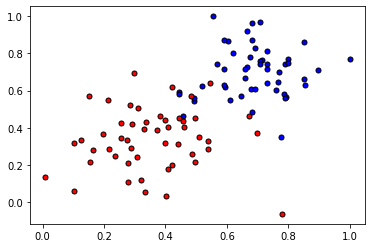

In [0]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Some helper functions for plotting and drawing lines

def plot_points(X, y):
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'blue', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'red', edgecolor = 'k')

def display(m, b, color='g--'):
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    x = np.arange(-10, 10, 0.1)
    plt.plot(x, m*x+b, color)

data = pd.read_csv('/content/data.csv', header=None)
X = np.array(data[[0,1]])
y = np.array(data[2])
plot_points(X,y)
plt.show()